In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import wordcloud
import tensorflow as tf
from tensorflow.keras  import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
%matplotlib inline

### Reading AnimeList Dataset

In [3]:
import os
INPUT_DIR = os.path.join("..", "artifacts", "raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory = True, usecols=["user_id", "anime_id", "rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

## Data Processing

In [7]:
n_ratings = rating_df['user_id'].value_counts()
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings >= 400].index)].copy()

In [8]:
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
13465        1
16480        1
16465        1
3465         1
16450        1
Name: count, Length: 15186, dtype: int64

In [9]:
len(rating_df)

3246641

In [10]:
min_rating = min(rating_df["rating"])

In [11]:
min_rating

0

In [12]:
max_rating = max(rating_df["rating"])

In [13]:
max_rating

10

In [14]:
avg_rating = np.mean(rating_df["rating"])

In [15]:
avg_rating

np.float64(4.122732695114736)

In [16]:
rating_df['rating'] = rating_df['rating'].apply(lambda x : (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

In [17]:
rating_df.duplicated().sum()

np.int64(0)

In [18]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [19]:
user_ids = rating_df['user_id'].unique().tolist()

In [20]:
user2user_encoded = {x : i for i,x in enumerate(user_ids)}

In [21]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [22]:
user2user_decoded = {i : x for i,x in enumerate(user_ids)}

In [28]:
user2user_decoded

{0: 2,
 1: 6,
 2: 12,
 3: 16,
 4: 17,
 5: 19,
 6: 21,
 7: 41,
 8: 42,
 9: 44,
 10: 47,
 11: 53,
 12: 55,
 13: 60,
 14: 66,
 15: 73,
 16: 74,
 17: 85,
 18: 89,
 19: 90,
 20: 94,
 21: 98,
 22: 102,
 23: 108,
 24: 111,
 25: 112,
 26: 120,
 27: 121,
 28: 122,
 29: 135,
 30: 145,
 31: 146,
 32: 147,
 33: 153,
 34: 155,
 35: 156,
 36: 172,
 37: 174,
 38: 184,
 39: 190,
 40: 193,
 41: 194,
 42: 198,
 43: 204,
 44: 205,
 45: 209,
 46: 214,
 47: 219,
 48: 222,
 49: 227,
 50: 228,
 51: 235,
 52: 238,
 53: 240,
 54: 243,
 55: 248,
 56: 251,
 57: 252,
 58: 257,
 59: 264,
 60: 267,
 61: 272,
 62: 274,
 63: 275,
 64: 284,
 65: 285,
 66: 286,
 67: 290,
 68: 291,
 69: 293,
 70: 300,
 71: 301,
 72: 306,
 73: 308,
 74: 310,
 75: 313,
 76: 314,
 77: 316,
 78: 320,
 79: 321,
 80: 324,
 81: 325,
 82: 326,
 83: 327,
 84: 330,
 85: 336,
 86: 340,
 87: 345,
 88: 346,
 89: 349,
 90: 350,
 91: 366,
 92: 367,
 93: 371,
 94: 372,
 95: 375,
 96: 381,
 97: 382,
 98: 386,
 99: 389,
 100: 398,
 101: 405,
 102: 406,
 

In [29]:
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)

In [30]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [32]:
n_users = len(user2user_encoded)

In [33]:
n_users

4203

In [34]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x : i for i,x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i,x in enumerate(anime_ids)}
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded)

In [35]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [36]:
n_anime = len(anime2anime_encoded)

In [37]:
n_anime

17149

In [38]:
rating_df = rating_df.sample(frac = 1, random_state = 43).reset_index(drop = True)

In [39]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [47]:
X = rating_df[['user', 'anime']].values
y = rating_df['rating']

In [48]:
test_size  = 1000
train_indices = rating_df.shape[0] - test_size

In [49]:
X_train,X_test,y_train,y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [50]:
len(X_train)

3245641

In [51]:
len(X_test)

1000

In [52]:
type(X_train)

numpy.ndarray

In [53]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [57]:
type(X_train_array)

list

In [55]:
type(X_train_array[0])

numpy.ndarray

## Model Architecture

In [60]:
def RecommendorNet():

    embedding_size = 128
    user = Input(name = "user", shape = [1])
    user_embedding = Embedding(name = 'user_embedding', input_dim = n_users, output_dim = embedding_size)(user)
    anime  = Input(name = "anime", shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding', input_dim = n_anime, output_dim = embedding_size)(anime)
    x = Dot(name = "dot_product", normalize = True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs = [user, anime], outputs = x)
    model.compile(loss = 'binary_crossentropy', metrics = ["mae", "mse"], optimizer = "Adam")

    return model

In [61]:
model = RecommendorNet()

In [62]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [64]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

In [65]:
def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr) / ramup_epochs*epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr

In [66]:
lr_callback = LearningRateScheduler(lambda epoch : lrfn(epoch), verbose = 0)
checkpoint_filepath = './weights.weights.h5'
model_checkpoint = ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = True, monitor = "val_loss", mode = "min", save_best_only = True)
early_stopping = EarlyStopping(patience = 3, monitor = 'val_loss',mode = "min", restore_best_weights = True)

In [67]:
my_call_backs = [model_checkpoint, lr_callback, early_stopping]

In [69]:
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test_array, y_test),
    callbacks = my_call_backs
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - loss: 0.5570 - mae: 0.2586 - mse: 0.0933 - val_loss: 0.5762 - val_mae: 0.2718 - val_mse: 0.1022 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - loss: 0.5556 - mae: 0.2577 - mse: 0.0927 - val_loss: 0.5726 - val_mae: 0.2678 - val_mse: 0.1009 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 0.5531 - mae: 0.2561 - mse: 0.0916 - val_loss: 0.5701 - val_mae: 0.2662 - val_mse: 0.0999 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 0.5496 - mae: 0.2537 - mse: 0.0901 - val_loss: 0.5671 - val_mae: 0.2642 - val_mse: 0.0986 - learning_rate: 3.4000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - loss: 0.5451 - mae: 0.2508 - mse: 0.0883 - val_loss: 0.5636 - val_mae: 0.2620 - val_mse: 0.0972 - learning_rate: 4.2000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - loss: 0.5400 - mae: 0.2473 - mse: 0.0861 - v

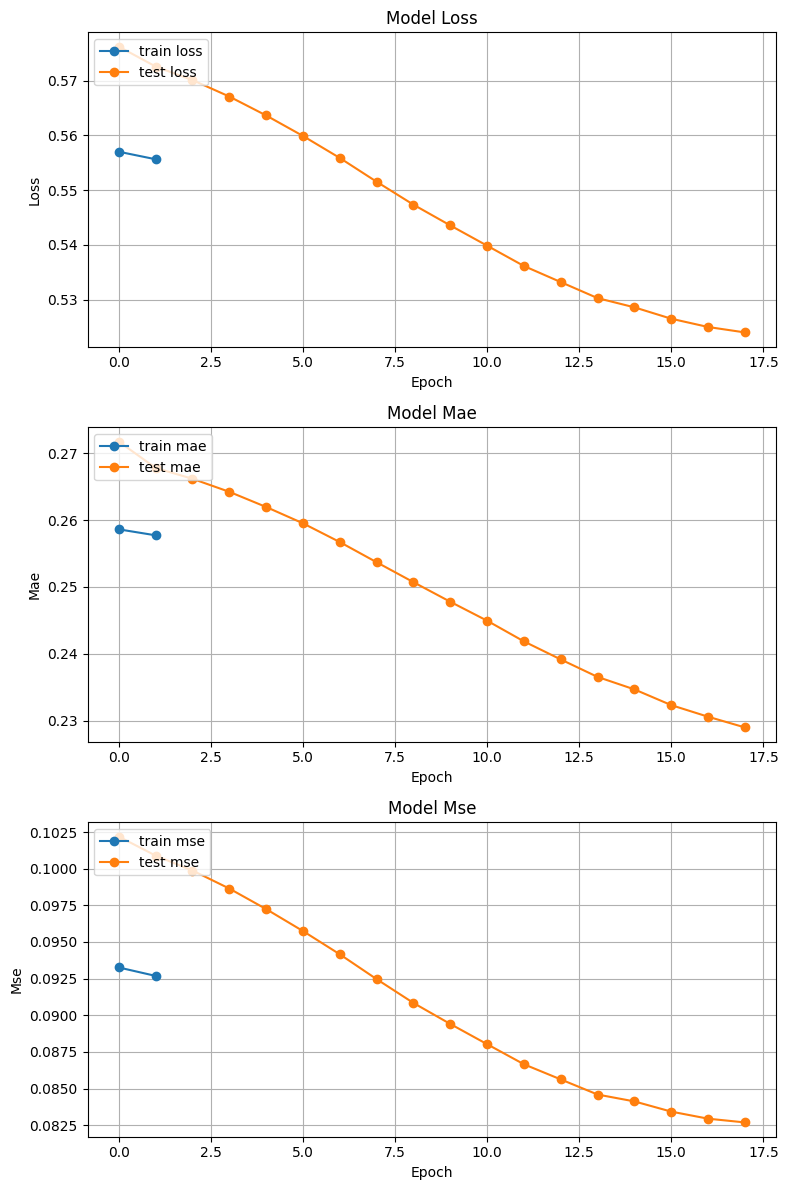

In [70]:
metrics = ['loss', 'mae', 'mse']

# Create Subplots
fig, axes = plt.subplots(len(metrics), 1, figsize = (8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:2], marker = 'o', label = f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker = 'o', label = f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc = 'upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [71]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape(-1,1)
    return weights

In [72]:
anime_weights = extract_weights("anime_embedding", model)

In [73]:
user_weights = extract_weights("user_embedding", model)

##  Reading Anime.csv

In [74]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory = True)

In [75]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [76]:
df = df.replace("Unknown", np.nan)

In [85]:
def getAnimeName(anime_id):
    name = None  # ensure it's always initialized
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if pd.isna(name):  # better check for NaN
            name = df[df.anime_id == anime_id].Name.values[0]
    except Exception as e:
        print(f"Error for anime_id {anime_id}: {e}")
    return name

In [86]:
df['anime_id'] = df['MAL_ID']
df['eng_version'] = df['English name']
df['eng_version'] = df.anime_id.apply(getAnimeName)

In [87]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [89]:
getAnimeName(6702)

'Fairy Tail'

In [92]:
df.sort_values(
    by = ['Score'],
    inplace = False,
    ascending = False,
    kind = 'quicksort',
    na_position = 'last',
)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [93]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [94]:
df = df[['anime_id', 'eng_version', "Score", "Genres", "Episodes","Type","Premiered", "Members"]]

In [95]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960
1,5,Cowboy Bebop:The Movie,8.39,"Action, Drama, Mystery, Sci-Fi, Space",1,Movie,NaN,273145
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",26,TV,Spring 1998,558913
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",26,TV,Summer 2002,94683
4,8,Beet the Vandel Buster,6.98,"Adventure, Fantasy, Shounen, Supernatural",52,TV,Fall 2004,13224


In [96]:
def getAnimeFrame(anime, df : pd.DataFrame):
    if isinstance(anime, int):
      return df[df.anime_id == anime]
    if isinstance(anime, str):
      return df[df.eng_version == anime]

In [98]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [99]:
getAnimeFrame('Witch Hunter Robin', df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",26,TV,Summer 2002,94683


## ANIME_WITH_SYNOPSIS.CSV

In [101]:
cols = ["MAL_ID","Name", "Genres", "sypnopsis"]

In [102]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols = cols)

In [108]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [104]:
def getsynopsis(anime, df : pd.DataFrame):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [105]:
getsynopsis(40028, synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [106]:
getsynopsis('Witch Hunter Robin', synopsis_df)

"ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"

# CONTENT/ITEM BASED RECOMMENDATION SYSTEM

In [107]:
pd.set_option("max_colwidth",None)

In [126]:
def find_similar_animes(name, weights, anime2anime_encoded, anime2anime_decoded,
                        df, synopsis_df, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        
        # ensure using the passed weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1

        if neg:
            closest = sorted_dists[:n]  # lowest similarities
        else:
            closest = sorted_dists[-n:]  # highest similarities

        print(f"Anime Closest to {name}")

        if return_dist:
            return dists, closest

        similarity_arr = []
        for close in closest:
            if close == encoded_index:  # skip itself
                continue
            decoded_id = anime2anime_decoded.get(close)
            if decoded_id is None:
                continue

            anime_frame = getAnimeFrame(decoded_id, df)
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            synopsis = getsynopsis(decoded_id, synopsis_df)
            similarity = dists[close]

            similarity_arr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre,
                "synopsis": synopsis
            })

        if not similarity_arr:  # safeguard
            print("No similar animes found.")
            return pd.DataFrame()

        Frame = pd.DataFrame(similarity_arr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"], axis=1)

    except Exception as e:
        print(f"Error occurred: {e}")
        return pd.DataFrame()


In [127]:
find_similar_animes(
    'Witch Hunter Robin',
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df, 
    n = 5
    )

Anime Closest to Witch Hunter Robin


,name,similarity,genre,synopsis
4,∀ Gundam,0.443875,"Action, Military, Sci-Fi, Adventure, Space, Drama, Romance, Mecha","It is the Correct Century, two millennia after a devastating conflict which left the world broken. Earth is now mostly uninhabitable, and thus a remnant of humanity has resided on the Moon while the Earth and its few survivors recover. For years, the ""Moonrace,"" the people of the Moon, have continued to check if Earth is fit for resettlement. A boy named Rolan Cehack and two others are sent down to Earth for a reconnaissance mission. Rolan ends up spending a year on the planet working for the Heim Family, aristocrats living in a Victorian-like society. This family, like others of similar wealthy status, celebrates one's coming of age with a ceremony involving a giant stone statue known as the ""White Doll."" To Rolan's surprise, the Moonrace suddenly touches down on Earth with the intent of taking it by force. During the attack, the White Doll is broken apart, revealing a mobile suit called the ""Turn A Gundam"" inside. With Rolan in its cockpit, the Turn A causes a standoff between the forces of Earth and Moon. The young pilot, along with the people of both sides, must keep the peace and avoid another all-out, catastrophic war."
3,Tweeny Witches,0.435032,"Adventure, Comedy, Fantasy, Magic","usu believes in magic. With all her heart, she believes that magic is possible and that it can be used for good deeds and fun games. But suddenly, she finds herself transported into another world, ruled by a mysterious elite of witches—and these witches don't seem to be in it for the fun. They're hard at work capturing sprites, the native magical beings of the world, and forcing them into slavery. Once Arusu realizes that her new surroundings aren't just a dream, she sets out to change things. (Source: ANN)"
2,Chrono Crusade,0.432609,"Action, Demons, Historical, Romance, Shounen, Supernatural","The 1920s was a decade of great change and upheaval, with monstrous demons appearing across America. To combat this menace, the holy organization known as the Order of Magdalene was established. The organization's New York branch is home to the young and reckless Sister Rosette Christopher, as well as her partner Chrno. Tasked with the extermination of demonic threats, the renowned team is excellent at their job, despite causing extensive collateral damage on their missions. However, both Rosette and Chrno are driven by their dark pasts. Through exterminating demons, Rosette hopes to find her lost brother Joshua who was taken by the sinner and demon, Aion, with whom Chrno also shares a bloody history. The two of them must fight off the increasingly dangerous demonic menace and discover its source, while continuing to search for the truth behind Joshua's disappearance."
1,Gilgamesh,0.415641,"Drama, Fantasy, Sci-Fi, Supernatural","The half-divine King of Uruk, Gilgamesh, was considered but a paltry legend... until his majestic tomb was discovered in the Middle East. This imperial crypt drew scientists from across the globe to the land, and with that came recognition of their fame. In a joint effort, they built Heaven's Gate in pursuit of advancing human knowledge. One day, a group of terrorists driven by greed attack Heaven's Gate, causing an explosion within the facility for archaeological excavation. The resulting phenomenon had much more impact than anyone could have imagined. More specifically, it triggered the birth of supernatural beings. In the midst of this mess, two siblings by the names of Kiyoko and Tatsuya encounter mysterious men with supernatural powers who, despite the scientific crisis around them, claim the ability to restore good to the world. Nevertheless, these seemingly heroic and all-powerful creatures act under the rule of factions. Are they here to save the world, or destroy it?"
0,Erin,0.413703,"Drama, Fantasy, Slice of Life","In the land of Ryoza, the neighboring provinces of Shin-Ou and Tai-Kou have been